In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as pe
from matplotlib.ticker import FormatStrFormatter

import corner

import utils

In [2]:
name = 'Luhman 16A'
#name = 'Luhman 16B'

#color_m = {'Luhman 16A': '#FF622E', 'Luhman 16B': '#396ED8'}[name]
color_m_A = '#FF622E'
color_m_B = '#396ED8'
lw_d = 0.8; lw_m = 1.0

q = 0.5 + np.array([-0.997/2, -0.95/2, -0.68/2, 0.0, 0.68/2, 0.95/2, 0.997/2])

In [3]:
prefix = '../retrieval_outputs/{}/test_'

prefixes = {
    'J_A': prefix.format('fiducial_J_A_ret_15_1column_n1000'), 
    'K_A': prefix.format('new_fiducial_K_A_ret_10'), 
    'J_B': prefix.format('fiducial_J_B_ret_51_1column_n1000'), 
    'K_B': prefix.format('new_fiducial_K_B_ret_5'), 
    }

def get_Chem_PT_contr(prefix_key):
    if prefix_key.startswith('J'):
        m_set, w_set = 'J1226_A', 'J1226'
    elif prefix_key.startswith('K'):
        m_set, w_set = f'K2166_{prefix_key[-1]}', 'K2166'

    Res = utils.RetrievalResults(
        prefix=prefixes[prefix_key], m_set=m_set, w_set=w_set, load_posterior=True
    )
    Chem  = Res._load_object('Chem')
    PT    = Res._load_object('PT')
    contr = np.load(f'{Res.prefix}data/bestfit_int_contr_em_{Res.m_set}.npy')
    return Chem, PT, contr

Chem_J_A, PT_J_A, contr_J_A = get_Chem_PT_contr('J_A')
Chem_J_B, PT_J_B, contr_J_B = get_Chem_PT_contr('J_B')
Chem_K_A, PT_K_A, contr_K_A = get_Chem_PT_contr('K_A')
Chem_K_B, PT_K_B, contr_K_B = get_Chem_PT_contr('K_B')

  analysing data from ../retrieval_outputs/fiducial_J_A_ret_15_1column_n1000/test_.txt
['modes', 'nested sampling global log-evidence', 'nested sampling global log-evidence error', 'global evidence', 'global evidence error', 'nested importance sampling global log-evidence', 'nested importance sampling global log-evidence error', 'marginals']
1399128.9058026907
1399123.4062811895
1399123.4062811895
  analysing data from ../retrieval_outputs/fiducial_J_B_ret_51_1column_n1000/test_.txt
['modes', 'nested sampling global log-evidence', 'nested sampling global log-evidence error', 'global evidence', 'global evidence error', 'nested importance sampling global log-evidence', 'nested importance sampling global log-evidence error', 'marginals']
1395569.7135439706
1395556.204842826
1395556.204842826
  analysing data from ../retrieval_outputs/new_fiducial_K_A_ret_10/test_.txt
['modes', 'nested sampling global log-evidence', 'nested sampling global log-evidence error', 'global evidence', 'global ev

In [4]:
def get_VMR_envelope(Chem):

    VMR_posterior = utils.convert_mf_dict_to_VMR_dict(
        Chem, relative_to_key='H2O'
        )
    VMR_envelope = {
        species_i: np.quantile(VMR_i, q=q, axis=0) \
        for species_i, VMR_i in VMR_posterior.items()
    }
    return VMR_envelope

VMR_env_J_A = get_VMR_envelope(Chem_J_A)
VMR_env_J_B = get_VMR_envelope(Chem_J_B)
VMR_env_K_A = get_VMR_envelope(Chem_K_A)
VMR_env_K_B = get_VMR_envelope(Chem_K_B)

In [6]:
color_m_J = 'mediumblue'
color_m_K = 'firebrick'

cmap_m_J = mpl.colors.LinearSegmentedColormap.from_list('', ['w',color_m_J])
env_colors_m_J = cmap_m_J([0.4,0.6,0.8])
env_colors_m_J[:,3] = 0.5

cmap_m_K = mpl.colors.LinearSegmentedColormap.from_list('', ['w',color_m_K])
env_colors_m_K = cmap_m_K([0.4,0.6,0.8])
env_colors_m_K[:,3] = 0.5

median_kwargs_J = {'c':color_m_J, 'lw':1.5}
median_kwargs_K = {'c':color_m_K, 'lw':1.5, 'ls':(0,(5,3))}

color_species = {
    'HF':'#FF59B4', '12CO':'C2', 'H2O':'C3', 'NH3':'C8', 'CH4':'C4', 'H2S':'#135D64', 
    'Na':'C1', 'K':'C0', 'FeH':'#00DBA8',
    }

#ylim = (1e3,1e-5)
ylim = (1e2,6e-3)

def plot_multicolor_line(ax, x, y, c_array, **kwargs):

    # Default the capstyle to butt so that the line segments smoothly line up
    kwargs['capstyle'] = 'butt'

    # Compute the midpoints of the line segments. Include the first and last points
    # twice so we don't need any special syntax later to handle them.
    x = np.asarray(x)
    y = np.asarray(y)
    x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
    y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))

    # Determine the start, middle, and end coordinate pair of each line segment.
    coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
    coord_mid   = np.column_stack((x, y))[:, np.newaxis, :]
    coord_end   = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
    segments    = np.concatenate((coord_start, coord_mid, coord_end), axis=1)

    from matplotlib.collections import LineCollection
    lc = LineCollection(segments)
    lc.set_alpha(c_array[:,-1])  # set the alphas of each segment
    lc.set_linewidth(kwargs['lw'])
    lc.set_color(kwargs['c'])

    return ax.add_collection(lc)

def plot_VMR_envelope(ax, VMR_envelope, P, species, median_kwargs, contr):

    def interp_VMR(VMR):
        return 10**np.interp(log_fine_P, log_P, np.log10(VMR))

    color = color_species.get(species, 'k')
    cmap = mpl.colors.LinearSegmentedColormap.from_list('', ['w',color])
    env_colors = cmap([0.4,0.6,0.8])
    env_colors[:,-1] = 0.5

    log_P  = np.log10(P)
    fine_P = np.logspace(log_P.min(), log_P.max(), 251)
    log_fine_P = np.log10(fine_P)
    fine_contr = np.interp(log_fine_P, xp=log_P, fp=contr)
    
    Y = np.vstack((P, P))
    for i, (idx_i, c_i) in enumerate(zip([(0,6),(1,5),(2,4)], env_colors[:3])):

        fine_VMR_l = interp_VMR(VMR_envelope[species][idx_i[0]])
        fine_VMR_h = interp_VMR(VMR_envelope[species][idx_i[1]])

        X = np.vstack((fine_VMR_l, fine_VMR_h)) # left, right edges
        Y = np.vstack((fine_P, fine_P))         # vertical coords
        
        # Colors at each pressure
        C = np.ones((1,len(fine_P)-1))[:,:,None] * c_i[None,None,:]
        C[:,:,-1] *= fine_contr[1:]/fine_contr.max() # Weight alpha by contribution
        ax.pcolormesh(X, Y, C, edgecolors='none', lw=1e-6)

    C = mpl.colors.to_rgba_array(median_kwargs['c'])
    C = C * np.ones_like(fine_P)[:,None] # Expand vertically
    C[:,-1] *= fine_contr/fine_contr.max() # Weight alpha by contribution
    
    if median_kwargs.get('ls','-') != '-':
        # Apply dashes to line-segments
        l1, l2 = 7, 5
        dashes = np.ones_like(fine_P)
        for i in range(0,len(dashes),l1+l2):
            dashes[i:i+l2] = 0
        C[:,-1] *= dashes

    # Plot line with an alpha-gradient    
    fine_median_VMR = interp_VMR(VMR_envelope[species][3])
    
    median_kwargs = median_kwargs.copy()
    median_kwargs['c'] = color
    plot_multicolor_line(ax, x=fine_median_VMR, y=fine_P, c_array=C, **median_kwargs)

    # Plot an errorbar at the average contribution
    x = np.average(fine_median_VMR, weights=fine_contr/fine_contr.max())
    y = np.average(fine_P, weights=fine_contr/fine_contr.max())

    # Upper and lower limits
    xerr_l = np.average(
        interp_VMR(VMR_envelope[species][0]), 
        weights=fine_contr/fine_contr.max()
        )
    xerr_h = np.average(
        interp_VMR(VMR_envelope[species][6]), 
        weights=fine_contr/fine_contr.max()
        )
    xerr = np.abs(np.array([xerr_l,xerr_h])-x)[:,None]
    
    # Plot a white outline too
    ax.errorbar(x, y=y, xerr=xerr, fmt='o', c='w', markersize=4, zorder=10)
    ax.errorbar(x, y=y, xerr=xerr, fmt='', c='w', elinewidth=2.5, capsize=1, zorder=11)
    ax.errorbar(x, y=y, xerr=xerr, fmt='o', c=color, elinewidth=1.5, markersize=3, zorder=12)
    
    return x, y

def indicate_JK_band(ax, name, P, **ann_kwargs):
    
    ann_kwargs = ann_kwargs.copy()
    ann_kwargs['fontsize'] = 15
    ann_kwargs['c'] = color_m_J if name=='J' else color_m_K

    ax.plot([0.98,1.02], [P]*2, transform=ax.get_yaxis_transform(), c='k', lw=0.8, clip_on=False)
    ax.annotate(name, xy=(1.05,P), xycoords=ax.get_yaxis_transform(), **ann_kwargs)

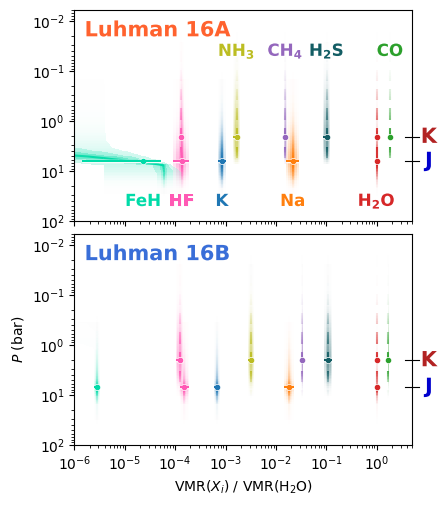

In [18]:
fig = plt.figure(figsize=(4.5,5.0))
gs = fig.add_gridspec(
    nrows=2, ncols=1, hspace=0.06, wspace=0.0, 
)
ax_VMR = np.array(
    [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[1,0])]
)

# --- VMR ----------------------------------------------
iterables = zip(
    ax_VMR, [VMR_env_J_A,VMR_env_J_B], [VMR_env_K_A,VMR_env_K_B], 
    [contr_J_A,contr_J_B], [contr_K_A,contr_K_B]
    )
for i, (ax_i, VMR_env_J_i, VMR_env_K_i, contr_J_i, contr_K_i) in enumerate(iterables):
        
    iterables_J = zip(
        ['H2O','HF','FeH','K','Na'], 
        [r'$\mathrm{\bf H_2O}$','HF','FeH','K','Na'], 
        [0,0,0,0,0], [0,0,0,0,0], 
        )
    iterables_K = zip(
        ['H2O','HF','12CO','CH4','NH3','H2S'], 
        ['','','CO',r'$\mathrm{\bf CH_4}$',r'$\mathrm{\bf NH_3}$',r'$\mathrm{\bf H_2S}$'], 
        [0,0,0,0,0,0], [0,0,0,0,0,0], 
        )
    ann_kwargs = dict(
        zorder=2, ha='center', va='center', fontsize=13, fontweight='bold', 
        path_effects=[pe.withStroke(linewidth=2, foreground='w', alpha=0.9)],
    )

    for species_i, label_i, dx_i, dy_i in iterables_J:
        ann_kwargs['fontsize'] = 12
        ann_kwargs['ha'] = 'center'

        VMR_i, P_i = plot_VMR_envelope(
            ax=ax_i, VMR_envelope=VMR_env_J_i, P=PT_J_A.pressure, 
            species=species_i, median_kwargs=median_kwargs_J, contr=contr_J_i
            )

        if i == 0:
            ann_kwargs['c'] = color_species[species_i]
            ax_i.annotate(label_i, xy=(10**(np.log10(VMR_i)+dx_i), 10**(np.log10(4e1)+dy_i)), **ann_kwargs)

    indicate_JK_band(ax_i, 'J', P=P_i, **ann_kwargs)

    for species_i, label_i, dx_i, dy_i in iterables_K:
        ann_kwargs['fontsize'] = 12
        ann_kwargs['ha'] = 'center'

        VMR_i, P_i = plot_VMR_envelope(
            ax=ax_i, VMR_envelope=VMR_env_K_i, P=PT_K_A.pressure, 
            species=species_i, median_kwargs=median_kwargs_K, contr=contr_K_i
            )
        
        if i == 0:
            ann_kwargs['c'] = color_species[species_i]
            ax_i.annotate(label_i, xy=(10**(np.log10(VMR_i)+dx_i), 10**(np.log10(4e-2)+dy_i)), **ann_kwargs)

    indicate_JK_band(ax_i, 'K', P=P_i, **ann_kwargs)

'''
x    = VMR_envelope_K['Na'][-2,0]
xerr = np.abs(10**(np.log10(x)-0.5) - x)
ax_VMR[0].errorbar(
    x=x, y=3e-1, xerr=xerr, fmt='|', xuplims=True, c=color_species['Na']
)

x    = VMR_envelope_K['K'][-2,0]
xerr = np.abs(10**(np.log10(x)-0.5) - x)
ax_VMR[0].errorbar(
    x=x, y=4e-1, xerr=xerr, fmt='|', xuplims=True, c=color_species['K']
)
'''

ann_kwargs['c'] = color_m_A; ann_kwargs['fontsize'] = 15
ann_kwargs['ha'] = 'left'; ann_kwargs['va'] = 'top'
ax_VMR[0].annotate('Luhman 16A', xy=(0.03,0.95), xycoords='axes fraction', **ann_kwargs)
ax_VMR[0].set(
    yscale='log', ylim=ylim, xscale='log', xlim=(1e-6,5e0), xticklabels=[]
    )

ann_kwargs['c'] = color_m_B; ann_kwargs['fontsize'] = 15
ax_VMR[1].annotate('Luhman 16B', xy=(0.03,0.95), xycoords='axes fraction', **ann_kwargs)
ax_VMR[1].set(
    yscale='log', ylim=ylim, ylabel=r'$P\ (\mathrm{bar})$', 
    xscale='log', xlim=ax_VMR[0].get_xlim(), xlabel=r'VMR($X_i$) / VMR($\mathrm{H_2O}$)'
    )

plt.subplots_adjust(left=0.17, bottom=0.1, top=0.97, right=0.92)
plt.savefig(f'./plots/JK_comp_VMR_profiles.pdf')
plt.show()